In [1]:
### reference: https://www.kaggle.com/code/gzuidhof/full-preprocessing-tutorial#3D-plotting-the-scan

In [2]:
%matplotlib inline

import numpy as np
import SimpleITK as sitk
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt

from skimage import measure

from utils import load_scan, plot_3d, normalize_planes

INPUT_FOLDER = r'D:/masters_datasets/LUNA16-original/LUNA16_Images/*.mhd'
exams = glob.glob(INPUT_FOLDER)
print(len(exams))
exams.sort()

888


In [3]:
for i, exam in enumerate(exams):
    if '1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456' in exam:
        print(exam, i)

D:/masters_datasets/LUNA16-original/LUNA16_Images\1.3.6.1.4.1.14519.5.2.1.6279.6001.183843376225716802567192412456.mhd 241


In [4]:
# itkimage = sitk.ReadImage(exams[80])
# ct_scan = sitk.GetArrayFromImage(itkimage)
# print(ct_scan.shape)
# origin = np.array(list(reversed(itkimage.GetOrigin())))
# spacing = np.array(list(reversed(itkimage.GetSpacing())))
# print(origin, spacing)
# origin = np.array(list(itkimage.GetOrigin()))
# spacing = np.array(list(itkimage.GetSpacing()))
# print(origin, spacing)

#### Loading the files

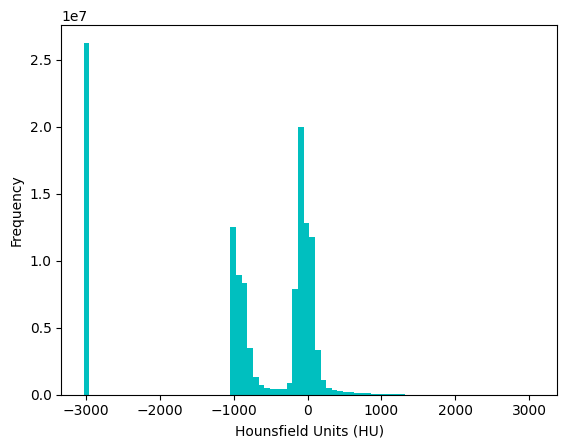

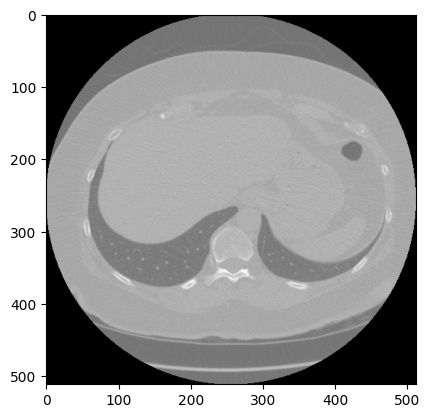

True

In [5]:
import cv2 as cv
from PIL import Image

first_exam_pixels = load_scan(exams[3])
plt.hist(first_exam_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

plt.imshow(first_exam_pixels[90], cmap=plt.cm.gray)
plt.show()

### normalizing histogram
image = normalize_planes(first_exam_pixels[90])
image = Image.fromarray(image*255).convert('L')
image.save('output/raw.png')

img = cv.imread('output/raw.png', cv.IMREAD_GRAYSCALE)

clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)
cl1 = np.hstack((img, cl1))
cv.imwrite('output/clahe_2.jpg',cl1)

equ = cv.equalizeHist(img)
res = np.hstack((img, equ))
cv.imwrite('output/norm.jpg', res)



In [6]:
int('aa')

ValueError: invalid literal for int() with base 10: 'aa'

#### 3D plotting the scan

In [ ]:
# plot_3d(first_exam_pixels, 400) ### show bones

#### Lung segmentation

In [ ]:
def largest_label_volume(im, bg=-1):
  vals, counts = np.unique(im, return_counts=True)

  counts = counts[vals != bg]
  vals = vals[vals != bg]

  if len(counts) > 0:
    return vals[np.argmax(counts)]
  else:
    return None
  
def segment_lung_mask(image, fill_lung_structures=True):
    
  # not actually binary, but 1 and 2. 
  # 0 is treated as background, which we do not want
  binary_image = np.array(image > -320, dtype=np.int8)+1
  labels = measure.label(binary_image)
  
  # Pick the pixel in the very corner to determine which label is air.
  #   Improvement: Pick multiple background labels from around the patient
  #   More resistant to "trays" on which the patient lays cutting the air 
  #   around the person in half
  background_label = labels[0,0,0]
  
  #Fill the air around the person
  binary_image[background_label == labels] = 2
  
  
  # Method of filling the lung structures (that is superior to something like 
  # morphological closing)
  if fill_lung_structures:
    # For every slice we determine the largest solid structure
    for i, axial_slice in enumerate(binary_image):
      axial_slice = axial_slice - 1
      labeling = measure.label(axial_slice)
      l_max = largest_label_volume(labeling, bg=0)
      
      if l_max is not None: #This slice contains some lung
        binary_image[i][labeling != l_max] = 1

  
  binary_image -= 1 #Make the image actual binary
  binary_image = 1-binary_image # Invert it, lungs are now 1
  
  # Remove other air pockets insided body
  labels = measure.label(binary_image, background=0)
  l_max = largest_label_volume(labels, bg=0)
  if l_max is not None: # There are air pockets
    binary_image[labels != l_max] = 0

  return binary_image

### unique plot

In [ ]:
segmented_lungs = segment_lung_mask(first_exam_pixels, False)
segmented_lungs_fill = segment_lung_mask(first_exam_pixels, True)

In [ ]:
# plot_3d(segmented_lungs, 0)

In [ ]:
print(np.unique(segmented_lungs_fill, return_counts=True))
print(type(segmented_lungs_fill))
print(segmented_lungs_fill.shape)
print(np.max(segmented_lungs_fill))
print(np.min(segmented_lungs_fill))

In [ ]:
# plot_3d(segmented_lungs_fill, 0)

In [ ]:
# plot_3d(segmented_lungs_fill - segmented_lungs, 0)

### Batch visualization

In [ ]:
for i in tqdm(range(0, 887)):
    current_exam = load_scan(exams[i])
    segmented_lungs_fill = segment_lung_mask(current_exam, True)
    output = np.unique(segmented_lungs_fill, return_counts=True)
    name = str(i) + '-' + str(round(output[1][1]/output[1][0], 5))
    plot_3d(segmented_lungs_fill, threshold=0, name='visualization/'+name)